https://learn.qiskit.org/v1/course/ch-algorithms/defining-quantum-circuits

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble, converters
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

# importing Qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
import qiskit.quantum_info as qi


C:\Users\lisis\AppData\Local\Temp\ipykernel_19292\190368713.py:15: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, X, Y, Z, H, CX, Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki, PauliSumOp


In [2]:
import numpy as np
import scipy.linalg as la
des = [0.5, 1]
n = len(des)
s = np.diag(des)
q, _ = la.qr(np.random.rand(n, n))
A = q.T @ s @ q
A = np.array([
    [1.5, 0.5],
    [0.5, 1.5],
    ]).astype('complex')
eigs_h, vecs_h = np.linalg.eig(A)
RESULTS = []
print(eigs_h)
# np.linalg.det(A)
# print(A)

[2.+0.j 1.+0.j]


In [3]:
# a = np.diag(np.ones(2))
# a[0,1] = 1
# print('the matrix is', '\n', a)
# eigs_h, vecs_h = np.linalg.eig(a)
# print('eigenvalues', '\n', eigs_h, '\n', 'eigenvectors', '\n', vecs_h)

In [4]:
# noise = np.random.normal(0,0.001,(2,2))/2
# noise = noise + noise.conj().T
# U = la.expm(1j*A)
# # U_noised = la.expm(1j*(A+noise))
# U_noise = la.expm(1j*(noise.T))
# U_noised = np.dot(U_noise, U)
# print(U)
# print(U_noised)
# print(np.dot(U, U_noise))

In [5]:
from sklearn.preprocessing import normalize
ERROR = 0.0
def add_noise_to_gate(U):
    noise = np.random.uniform(-ERROR,ERROR,U.shape)
    # print(noise)
    # noise = np.random.normal(0, ERROR, U.shape)/2
    noise = noise + noise.conj().T
    U_noise = la.expm(1j*(noise.T))
    U = np.dot(U_noise, U)
    return U

In [6]:
U = la.expm(1j*A)
eigs_u, vecs_u = np.linalg.eig(U)
print(eigs_u)#, vecs_u)

[ 0.54030231+0.84147098j -0.41614684+0.90929743j]


In [19]:
n_of_qubs = 10
qpe = QuantumCircuit(n_of_qubs+1, n_of_qubs)
qpe.initialize(vecs_u[1], n_of_qubs)

In [20]:
# for qubit in range(n_of_qubs):
import time
qpe_clear = QuantumCircuit(n_of_qubs+1)
for qubit in range(n_of_qubs):
    qpe_clear.h(qubit)
    
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)

qpe.append(U_h, range(n_of_qubs+1))    
# print(qpe)

In [21]:
gate = UnitaryGate(U).control(1)
repetitions = 1
qpe_clear = QuantumCircuit(n_of_qubs+1)
for i in range(0, n_of_qubs):
    for _ in range(repetitions):
        qpe_clear.append(gate,[i, n_of_qubs])
    repetitions *= 2
    
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
# print(op)
op = add_noise_to_gate(op)
# print(op)
U_h = UnitaryGate(op)

qpe.append(U_h, range(n_of_qubs+1))

In [22]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [23]:
qpe.barrier()
# Apply inverse QFT
qpe_clear = QuantumCircuit(n_of_qubs+1)
qft_dagger(qpe_clear, n_of_qubs)
backend = Aer.get_backend('unitary_simulator')
job = execute(qpe_clear, backend)
result = job.result()
op = result.get_unitary(qpe_clear).data
op = add_noise_to_gate(op)
U_h = UnitaryGate(op)
qpe.append(U_h, range(n_of_qubs+1))
# Measure
qpe.barrier()
for n in range(n_of_qubs):
    qpe.measure(n,n)

C:\Users\lisis\AppData\Local\Temp\ipykernel_19292\1036835033.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = aer_sim.run(qobj).result()


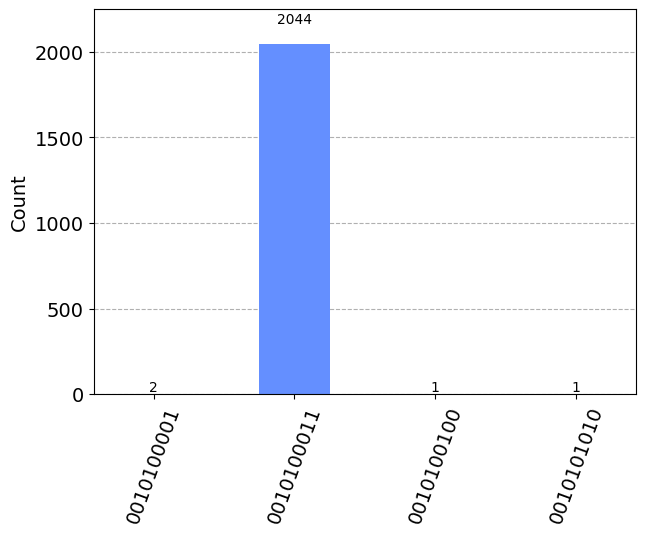

In [24]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
answer_to_plot = answer.copy()
answer = sorted(answer.items(), key=lambda x:x[1])
new_ans = []
for pair in answer:
    new_ans.append((int(pair[0],2), pair[1]))
answer = new_ans
plot_histogram(answer_to_plot)

In [25]:
# qpe.draw()

In [26]:
print(answer)

[(170, 1), (164, 1), (161, 2), (163, 2044)]


In [27]:
import scipy.linalg as la
# print(la.expm(1j*4*np.pi*0/shots))
print(la.expm(1j*2*np.pi*163/(2**n_of_qubs)))

[[0.54017147+0.84155498j]]


In [28]:
eigs_u

array([ 0.54030231+0.84147098j, -0.41614684+0.90929743j])

# Answers sorting and plotting

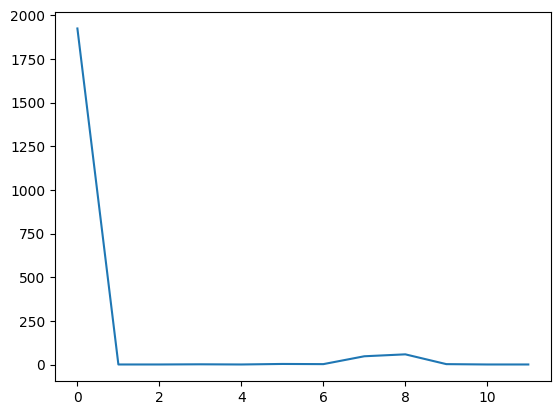

In [81]:
answer_copy = answer.copy()
answer_copy.sort(key=lambda x: x[0])
y = [val[1] for val in answer_copy]
x = [val[0] for val in answer_copy]
RESULTS.append((ERROR, x, y))
plt.plot(y)

In [77]:
# RESULTS.append((ERROR, histogram))

In [13]:
len(RESULTS)

0

# Results are already solved

In [23]:
import json
# Opening JSON file
f = open('2.json')
# returns JSON object as 
# a dictionary
data = json.load(f)
# print(data)
# Iterating through the json
# list
RESULTS = []
for key in data:
     RESULTS.append([key, data[str(key)]['x'], data[str(key)]['y']])

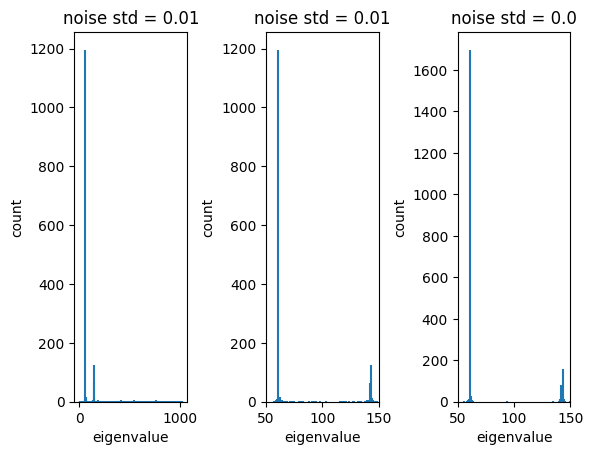

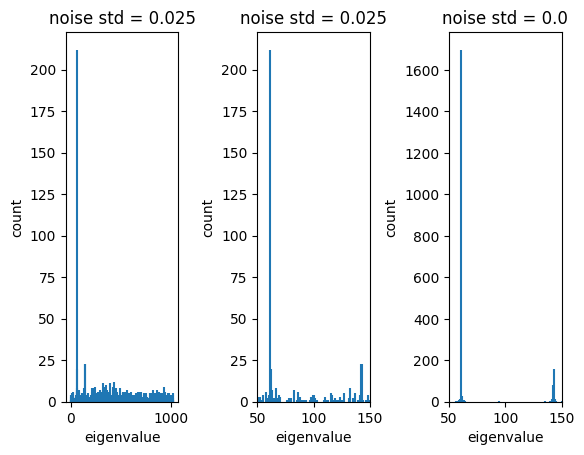

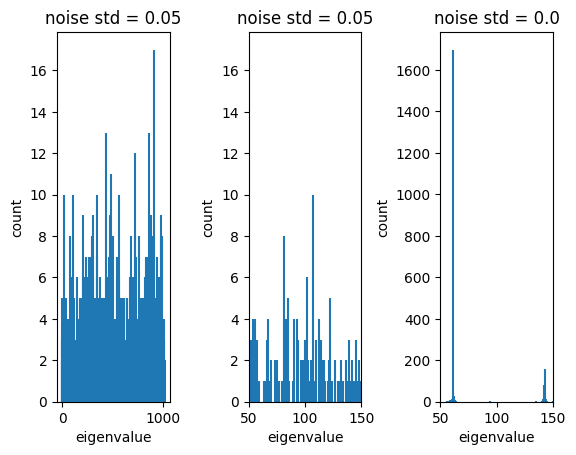

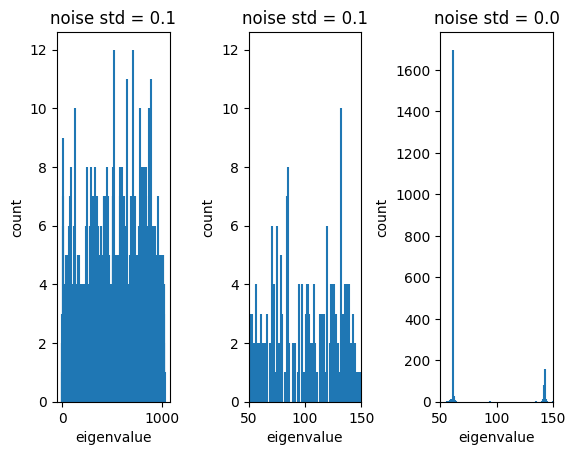

In [34]:
for tupple in RESULTS[1:]:
    fig = plt.figure()
    fig.subplots_adjust(hspace=1.7, wspace=0.7)
    plt.subplot(1, 3, 1)
    # plt.plot(tupple[1], tupple[2])
    plt.vlines(tupple[1],0,tupple[2])
    plt.title(f'noise std = {tupple[0]}')
    plt.xlabel('eigenvalue')
    plt.ylabel('count')
    plt.ylim(0)
    
    plt.subplot(1, 3, 2)
    # plt.plot(tupple[1], tupple[2])
    plt.vlines(tupple[1],0,tupple[2])
    plt.title(f'noise std = {tupple[0]}')
    plt.xlim(50, 150)
    plt.xlabel('eigenvalue')
    plt.ylabel('count')
    plt.ylim(0)
    
    plt.subplot(1, 3, 3)
    plt.vlines(RESULTS[0][1],0,RESULTS[0][2])
    plt.title(f'noise std = {RESULTS[0][0]}')
    plt.xlim(50, 150)
    plt.xlabel('eigenvalue')
    plt.ylabel('count')
    plt.ylim(0)
    
    plt.show()

In [46]:
# plt.plot(tupple[1], tupple[2])
# plt.title(f'noise std = {tupple[0]}')
# plt.plot(RESULTS[0][1], RESULTS[0][2])
# plt.title(f'noise std = {RESULTS[0][0]}')
# plt.show()

# In JSON format

In [100]:
result = {}
for tupple in RESULTS:
    result[tupple[0]] = {
        'x': tupple[1],
        'y': tupple[2]
    }

In [101]:
# import json

# # Serialize data into file:
# json.dump( result, open( "2.json", 'w' ) )

In [28]:
print(ERROR)
noise = np.random.uniform(-ERROR,ERROR,U.shape)
print(noise)
# count, bins, ignored = plt.hist(noise, 15, density=True)
# plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
# plt.show()

0.01
[[ 0.00934203  0.00864836]
 [-0.00226216 -0.00536088]]
